In [1]:
import tensorflow as tf
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
from os import path
import shutil
from keras.preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa
import glob


dtype = torch.float
device = torch.device("cpu")

In [2]:
tf.__version__

'2.8.0'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:

#src = "chest_xray/train/PNEUMONIA"
#dst1 = "chest_xray/train/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/train/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)


In [4]:
#src = "chest_xray/test/PNEUMONIA"
#dst1 = "chest_xray/test/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/test/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)

In [4]:
data_dir = './chest_xray/train'
img_height = 180
img_width = 180
batchSize = 16

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height,img_width),
                                                       batch_size=batchSize
                                                      )


Found 5216 files belonging to 3 classes.
Using 4173 files for training.


In [6]:
normal_count = len(glob.glob(data_dir+"/NORMAL/*"))
pneumonia_virus = len(glob.glob(data_dir+"/PNEUMONIA_VIRUS/*"))
pneumonia_bacterial = len(glob.glob(data_dir+"/PNEUMONIA_BACTERIAL/*"))

In [8]:
print(normal_count)
print(pneumonia_virus)
print(pneumonia_bacterial)

1341
1345
2530


In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batchSize)

Found 5216 files belonging to 3 classes.
Using 1043 files for validation.


In [40]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRUS']


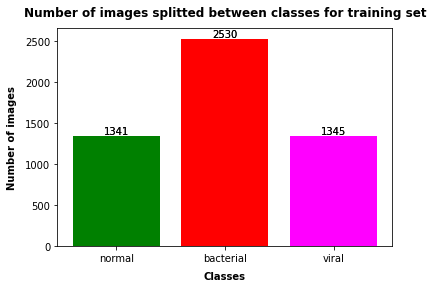

In [37]:
# plt.bar(x=["normal", "bacterial", "viral"], height=[normal_count, pneumonia_bacterial, pneumonia_virus])


fig, ax = plt.subplots()
bars = ax.bar(["normal", "bacterial", "viral"],[normal_count, pneumonia_bacterial, pneumonia_virus], color=["green", "red", "magenta"])

ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)
plt.xlabel("Classes", labelpad=8.0, loc="center",fontweight="bold")
plt.ylabel("Number of images",labelpad=8.0, fontweight="bold")
plt.title("Number of images splitted between classes for training set",pad=12.0, fontweight="bold")
plt.show()

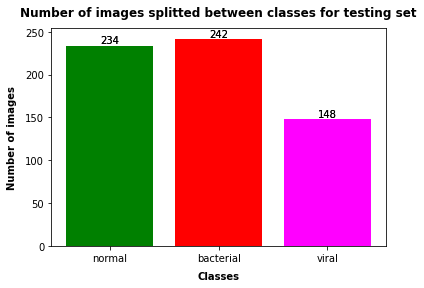

In [38]:
# plt.bar(x=["normal", "bacterial", "viral"], height=[normal_count, pneumonia_bacterial, pneumonia_virus])
test_data_dir = "./chest_xray/test"
normal_count = len(glob.glob(test_data_dir+"/NORMAL/*"))
pneumonia_virus = len(glob.glob(test_data_dir+"/PNEUMONIA_VIRUS/*"))
pneumonia_bacterial = len(glob.glob(test_data_dir+"/PNEUMONIA_BACTERIAL/*"))

fig, ax = plt.subplots()
bars = ax.bar(["normal", "bacterial", "viral"],[normal_count, pneumonia_bacterial, pneumonia_virus], color=["green", "red", "magenta"])

ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)
plt.xlabel("Classes", labelpad=8.0, loc="center",fontweight="bold")
plt.ylabel("Number of images",labelpad=8.0, fontweight="bold")
plt.title("Number of images splitted between classes for testing set",pad=12.0, fontweight="bold")
plt.show()

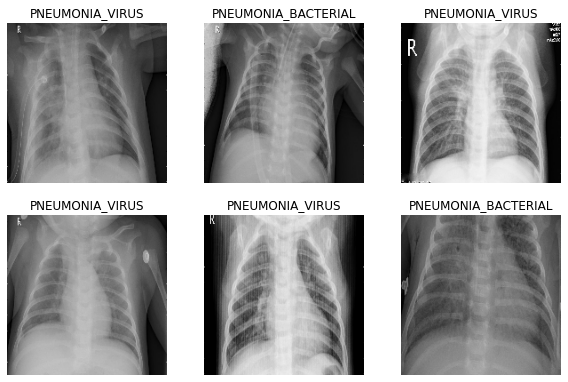

In [44]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
data_augmentation = keras.Sequential(
  [
    #layers.RandomFlip("horizontal",input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)

In [18]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (2,2), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (4,4), strides=(1, 1), padding='same'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (8,8), strides=(1, 1), padding='same'),
   layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2DTranspose(64, 3, strides=(4,4), padding='same',activation='relu'),
  #layers.MaxPooling2D(pool_size = (16,16), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (8,8), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (4,4), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (4,4), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #layers.BatchNormalization(),
    layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,),
              #optimizer=tf.keras.optimizers.Adam(),
                #loss=tf.keras.losses.binary_crossentropy,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 90, 90, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)       

In [21]:
#tf.config.set_soft_device_placement(True) 
with tf.device('/cpu:0'):   
    epochs=200
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size = batchSize,
      #shuffle = True
    
    


    )
#sess = tf.Session(config=tf.ConfigProto(
 #     allow_soft_placement=True, log_device_placement=True))

#print(sess.run(history))

Epoch 1/200
261/261 [==============================] - 206s 723ms/step - loss: 0.9485 - accuracy: 0.5847 - val_loss: 1.2908 - val_accuracy: 0.4008
Epoch 2/200
261/261 [==============================] - 180s 690ms/step - loss: 0.7640 - accuracy: 0.6588 - val_loss: 0.7053 - val_accuracy: 0.6721
Epoch 3/200
261/261 [==============================] - 179s 687ms/step - loss: 0.7026 - accuracy: 0.6916 - val_loss: 0.7723 - val_accuracy: 0.6759
Epoch 4/200
261/261 [==============================] - 191s 730ms/step - loss: 0.6710 - accuracy: 0.7029 - val_loss: 0.8759 - val_accuracy: 0.6366
Epoch 5/200
261/261 [==============================] - 186s 713ms/step - loss: 0.6476 - accuracy: 0.7251 - val_loss: 0.7808 - val_accuracy: 0.6711
Epoch 6/200
261/261 [==============================] - 174s 666ms/step - loss: 0.6306 - accuracy: 0.7235 - val_loss: 1.1566 - val_accuracy: 0.5561
Epoch 7/200
261/261 [==============================] - 155s 594ms/step - loss: 0.6289 - accuracy: 0.7316 - val_loss: 1

261/261 [==============================] - 147s 565ms/step - loss: 0.4141 - accuracy: 0.8164 - val_loss: 0.7144 - val_accuracy: 0.7248
Epoch 112/200
261/261 [==============================] - 148s 566ms/step - loss: 0.4181 - accuracy: 0.8203 - val_loss: 0.5099 - val_accuracy: 0.7891
Epoch 113/200
261/261 [==============================] - 148s 567ms/step - loss: 0.4151 - accuracy: 0.8229 - val_loss: 1.2204 - val_accuracy: 0.6079
Epoch 114/200
261/261 [==============================] - 149s 571ms/step - loss: 0.4171 - accuracy: 0.8196 - val_loss: 0.5278 - val_accuracy: 0.7919
Epoch 115/200
261/261 [==============================] - 149s 569ms/step - loss: 0.4132 - accuracy: 0.8140 - val_loss: 0.6684 - val_accuracy: 0.7622
Epoch 116/200
261/261 [==============================] - 150s 574ms/step - loss: 0.4126 - accuracy: 0.8184 - val_loss: 0.5522 - val_accuracy: 0.7603
Epoch 117/200
261/261 [==============================] - 149s 569ms/step - loss: 0.4141 - accuracy: 0.8179 - val_loss: 0

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_normal_path = "chest_xray/test/NORMAL/"
test_bacterial_path= "chest_xray/test/PNEUMONIA_BACTERIAL"
test_virus_path= "chest_xray/test/PNEUMONIA_VIRUS"

test_files_bacteria = [i for i in os.listdir(test_bacterial_path) if "bacteria" in i and path.isfile(path.join(test_bacterial_path, i))]
test_files_virus = [i for i in os.listdir(test_virus_path) if "virus" in i and path.isfile(path.join(test_virus_path, i))]
test_files_normal = [i for i in os.listdir(test_normal_path) if "NORMAL" in i and path.isfile(path.join(test_normal_path, i))]
img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[0]), target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch



In [ ]:
count = 0
for index in range(len(test_files_normal)):
    img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "NORMAL":
        count+=1

        
print("Accuracy for normal = ", count/len(test_files_normal) *100, "%")


In [ ]:
count = 0
diagnosed = 0
for index in range(len(test_files_bacteria)):
    img = tf.keras.utils.load_img(
    path.join(test_bacterial_path, test_files_bacteria[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
    

print("Accuracy for bacterial pneumonia = ", count/len(test_files_bacteria) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_bacteria) *100, "%")

In [ ]:
count = 0
diagnosed = 0
for index in range(len(test_files_virus)):
    img = tf.keras.utils.load_img(
    path.join(test_virus_path, test_files_virus[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
print("Accuracy for viral pneumonia = ", count/len(test_files_virus) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_virus) *100, "%")

In [ ]:
!mkdir -p saved_model9
model.save('saved_model9/my_model')

In [ ]:
ls saved_model9/my_model

In [ ]:
with open("./result_model9.txt",'w') as f:
    for k in history.history.keys():
        print(k,file=f)
        for i in history.history[k]:
            print(i,file=f)